# Прогнозирование оттока клинтов Телеком-компании

Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. 


<font color='green'>Цель</font>

Выбрать оптимальную модель для предсказания оттока клиентов.

<font color='green'>Задачи</font>

- исследовать данные;
- подготовить данные;
- создать модель;
- исследовать основные факторы;

<font color='green'>Таблицы БД </font>

- `contract` — информация о договоре;
- `personal` - персональные данные клиента;
- `internet` - информация об интернет-услугах;
- `phone` - информация об услугах телефонии.

<font color='green'>Признаки</font>

`telecom.contract` (информация о договоре)

- `customerID` — ID пользователя,
- `BeginDate` — дата начала действия,
- `EndDate` — дата окончания действия,
- `Type` — тип оплаты (раз в год или помесячно),
- `PaperlessBilling` — безбумажный расчётный лист,
- `PaymentMethod` — тип платежа,
- `MonthlyCharges` — расход за месяц,
- `TotalCharges` — общие расходы.


`telecom.personal` (персональные данные клиента)

- `customerID` — ID пользователя,
- `gender` — пол,
- `SeniorCitizen` — является ли абонент пенсионером,
- `Partner` — есть ли у абонента супруг/супруга,
- `Dependents` — есть ли у абонента дети.

`telecom.internet` (информация об интернет-услугах)

- `customerID` — ID пользователя,
- `InternetService` — тип подключения,
- `OnlineSecurity` — блокировка небезопасных сайтов,
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных,
- `DeviceProtection` — антивирус,
- `TechSupport` — выделенная линия технической поддержки,
- `StreamingTV` — стриминговое телевидение,
- `StreamingMovies` — каталог фильмов.


`telecom.phone` (информация об интернет-услугах)

- `customerID` — ID пользователя,
- `MultipleLines` — подключение телефонного аппарата к нескольким линиям одновременно.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-обработка-данных" data-toc-modified-id="Загрузка-и-обработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и обработка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li><li><span><a href="#OHE-и-масштабирование-признаков" data-toc-modified-id="OHE-и-масштабирование-признаков-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>OHE и масштабирование признаков</a></span></li><li><span><a href="#Выбор-модели" data-toc-modified-id="Выбор-модели-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Выбор модели</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li></ul></div>

## Загрузка и обработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

from sqlalchemy import create_engine 
#import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import  roc_auc_score, confusion_matrix, make_scorer, f1_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import skorch
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetClassifier

import random
import time

from sklearn.exceptions import FitFailedWarning
import warnings
warnings.simplefilter("ignore", FitFailedWarning)

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

In [3]:
query = '''

SELECT *
FROM telecom.contract
''' 
pd.read_sql_query(query, con = engine).to_csv('/ML/datasets/contract.csv', index=False)
contract = pd.read_csv('/ML/datasets/contract.csv', parse_dates=['BeginDate', 'EndDate'])
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,NaT,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,NaT,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,NaT,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,NaT,Month-to-month,Yes,Electronic check,29.60,346.45


In [4]:
query = '''

SELECT *
FROM telecom.personal
''' 
pd.read_sql_query(query, con = engine).to_csv('/ML/datasets/personal.csv', index=False)
personal = pd.read_csv('/ML/datasets/personal.csv')
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [5]:
query = '''

SELECT *
FROM telecom.internet
''' 
pd.read_sql_query(query, con = engine).to_csv('/ML/datasets/internet.csv', index=False)
internet = pd.read_csv('/ML/datasets/internet.csv', header=1)
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [6]:
query = '''

SELECT *
FROM telecom.phone
''' 
pd.read_sql_query(query, con = engine).to_csv('/ML/datasets/phone.csv', index=False)
phone = pd.read_csv('/ML/datasets/phone.csv', header=1)
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


У всех таблиц имеется общий ключ - `'customerID'`. Целевые данные содержатся в таблице `'contract'`, используем ее как базу для формирования общего файла.

In [7]:
data = contract.merge(personal, on='customerID', how='left').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')
data.head().T

,0,1,2,3,4
customerID,4472-LVYGI,3115-CZMZD,3668-QPYBK,5709-LVOEQ,9237-HQITU
BeginDate,2020-02-01 00:00:00,2020-02-01 00:00:00,2018-08-09 00:00:00,2020-02-01 00:00:00,2019-01-26 00:00:00
EndDate,NaT,NaT,2019-12-01 00:00:00,NaT,2019-11-01 00:00:00
Type,Two year,Two year,Month-to-month,Two year,Month-to-month
PaperlessBilling,Yes,No,Yes,No,Yes
PaymentMethod,Bank transfer (automatic),Mailed check,Mailed check,Mailed check,Electronic check
MonthlyCharges,52.55,20.25,53.85,80.85,70.7
TotalCharges,NaN,NaN,108.15,NaN,151.65
gender,Female,Male,Male,Female,Female
SeniorCitizen,0,0,0,0,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

Создадим целевую переменную. `1` - клиент ушел, `0` - действующий клиент.

In [9]:
data[['exited']] = 1
data.loc[data['EndDate'].isnull(), 'exited'] = 0

Создадим новый признак - кол-во дней активного договора. Для активных пользователей 'EndDate' будем считать равной '2020-02-01', т.к. на эту дату предоставлены данные. Столбцы 'customerID', 'BeginDate' и 'EndDate' удалим.

In [10]:
data['EndDate'] = data['EndDate'].fillna(pd.Timestamp('2020-02-01 00:00:00'))
data['days'] = (data['EndDate'] - data['BeginDate']).dt.days
data = data.drop(['EndDate', 'BeginDate', 'customerID'], axis=1)

Посмотрим на пропуски.

In [11]:
data.isna().sum()

Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
exited                 0
days                   0
dtype: int64

In [12]:
data.loc[(data['days'] == 0) & (data['TotalCharges'].isnull()), 'Type'].count()

11

Пропуски в столбце 'TotalCharges' заменим значениями из стобца 'MonthlyCharges'.

In [13]:
data['TotalCharges'] = data['TotalCharges'].fillna(data['MonthlyCharges'])

Оставшиеся пропуски заменим значением 'No'.

In [14]:
data = data.fillna('No')

In [15]:
data.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
exited              0
days                0
dtype: int64

Проверим данные на дубликаты.

In [16]:
data.duplicated().sum()

0

**Вывод**

Стратегии заполнения пропусков:

    - 'EndDate': const = Timestamp('2020-02-01 00:00:00';
    - 'TotalCharges': соответствующее значение 'MonthlyCharges';
    -  Other: const = 'No'.
    
Добавлены новые признаки:

    - целевая переменная 'exited': 1 - клиент ушел, 0 - действующий клиент.
    - кол-во дней активного договора ('EndDate'  - 'BeginDate')
    
Удалены признаки:

    - 'customerID'
    - 'BeginDate'
    - 'EndDate'    

## Анализ данных

In [17]:
data['exited'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: exited, dtype: float64

Классы не сбалансированы.

In [18]:
numerical = ['MonthlyCharges', 'TotalCharges', 'days']
target = ['exited']
categorical  = [col for col in data.columns if (col not in numerical+target) and (col != 'customerID')]

Статистические показатели для действующих клиентов.

In [19]:
data.loc[data['exited'] == 0][numerical].describe()

,MonthlyCharges,TotalCharges,days
count,5174.000000,5174.000000,5174.000000
mean,61.265124,2549.999497,296.437959
std,31.092648,2329.858843,83.654812
min,18.250000,18.800000,0.000000
25%,25.100000,572.900000,241.000000
50%,64.425000,1679.525000,297.000000
75%,88.400000,4262.850000,351.000000
max,118.750000,8672.450000,583.000000


Статистические показатели для клиентов, разорвавших договор.

In [20]:
data.loc[data['exited'] == 1][numerical].describe()

,MonthlyCharges,TotalCharges,days
count,1869.000000,1869.000000,1869.000000
mean,74.441332,1531.796094,299.982879
std,24.666053,1890.822994,84.423849
min,18.850000,18.850000,42.000000
25%,56.150000,134.500000,244.000000
50%,79.650000,703.550000,299.000000
75%,94.200000,2331.300000,353.000000
max,118.350000,8684.800000,554.000000


Среднее значение ежемесячных расходов выше для категории клиентов разорвавших договор, при этом стандартное отклонение для этой группы ниже. Посмотрим на графики.

In [21]:
def plot_numerical(column):
    sns.histplot(data=data, x=column, hue='exited')
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.title(f'Данные по столбцу "{column}"', fontsize=15)
    plt.legend(['Ушедшие клиенты', 'Действующие клиенты'])
    plt.show()

In [22]:
def plot_categorical(column):

    
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    explode = (0.05, 0) 
    
    ax = data.loc[data['exited'] == 0][column].value_counts().plot(kind='pie', fontsize=14, shadow=True, \
                                  title='Действующие клиенты', figsize=(20,5),
                                  ax=axes[1], autopct='%1.1f%%', labels=None)
    ax.legend((data.loc[data['exited'] == 0][column]).value_counts().index, bbox_to_anchor=(0.897,0.87), prop={'size':12})
    ax.set_ylabel('')
    ax.title.set_size(15)
    
    
    ax =  data.loc[data['exited'] == 1][column].value_counts().plot(kind='pie', fontsize=14, shadow=True, \
                                  title='Ушедшие клиенты', figsize=(20,5),
                                  ax=axes[0], autopct='%1.1f%%', labels=None)
    ax.legend((data.loc[data['exited'] == 1][column]).value_counts().index, bbox_to_anchor=(0.897,0.87), prop={'size':12})
    ax.set_ylabel('')
    ax.title.set_size(15)
    plt.suptitle(f'Данные по столбцу "{column}"', fontsize=18)
    plt.show()

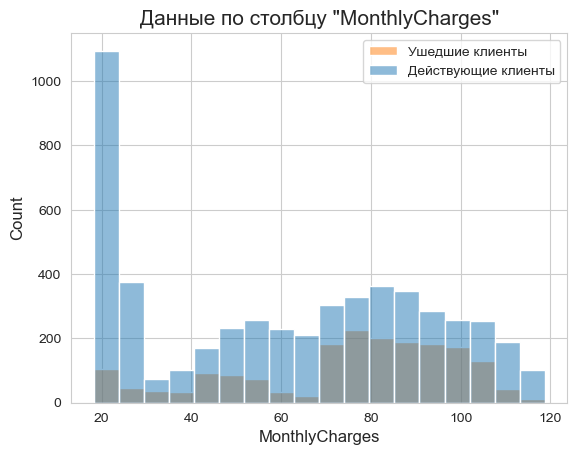

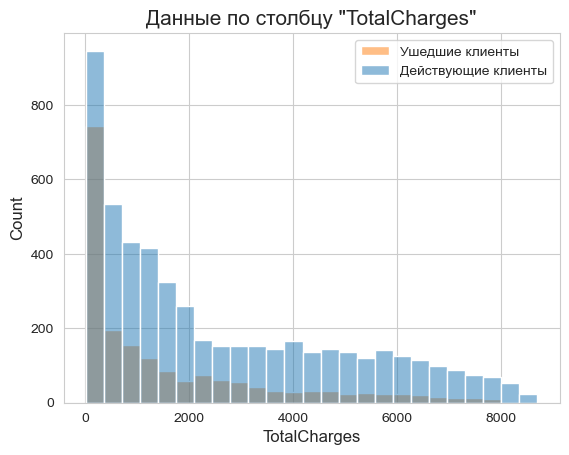

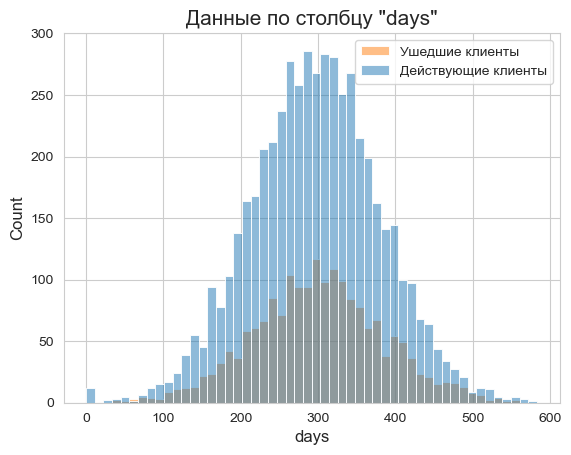

In [23]:
for column in numerical:
    plot_numerical(column)

Наблюдается отличие распределения по признаку `'MonthlyCharges'`: для действующих клиентов характерен глобальный максимум вблизи min значения. 

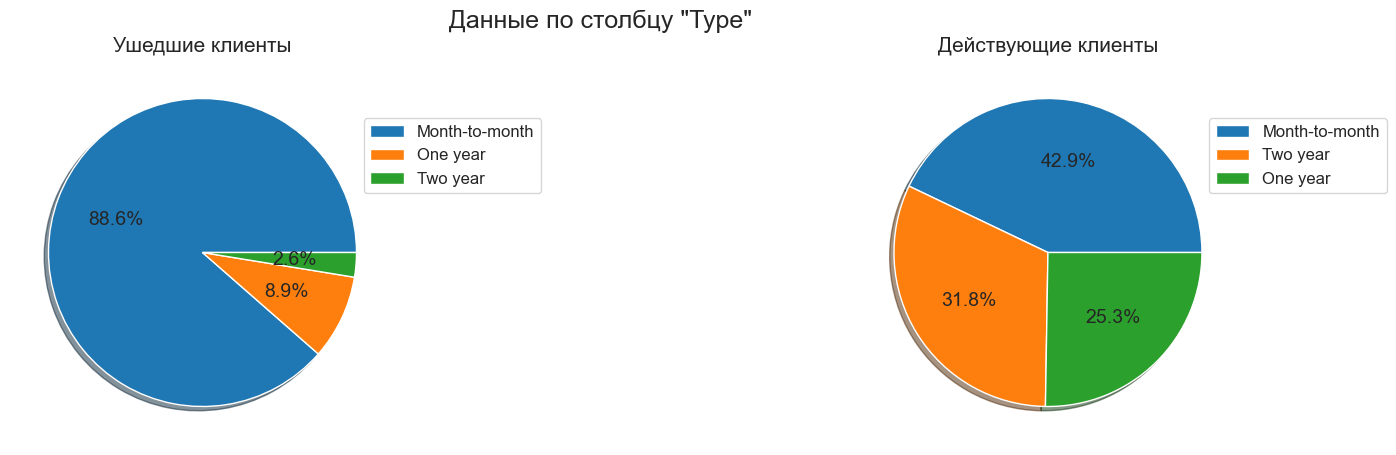

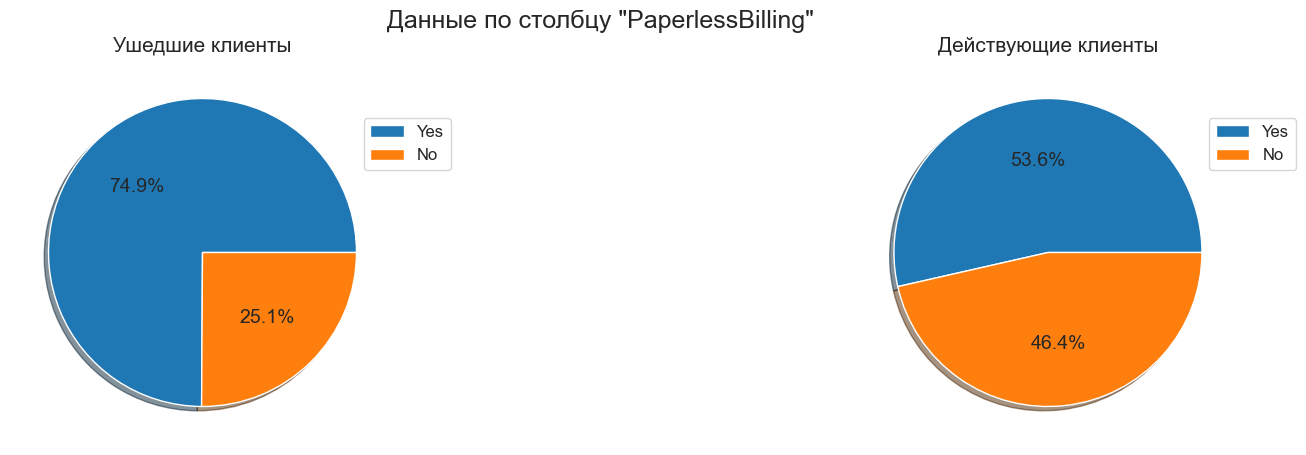

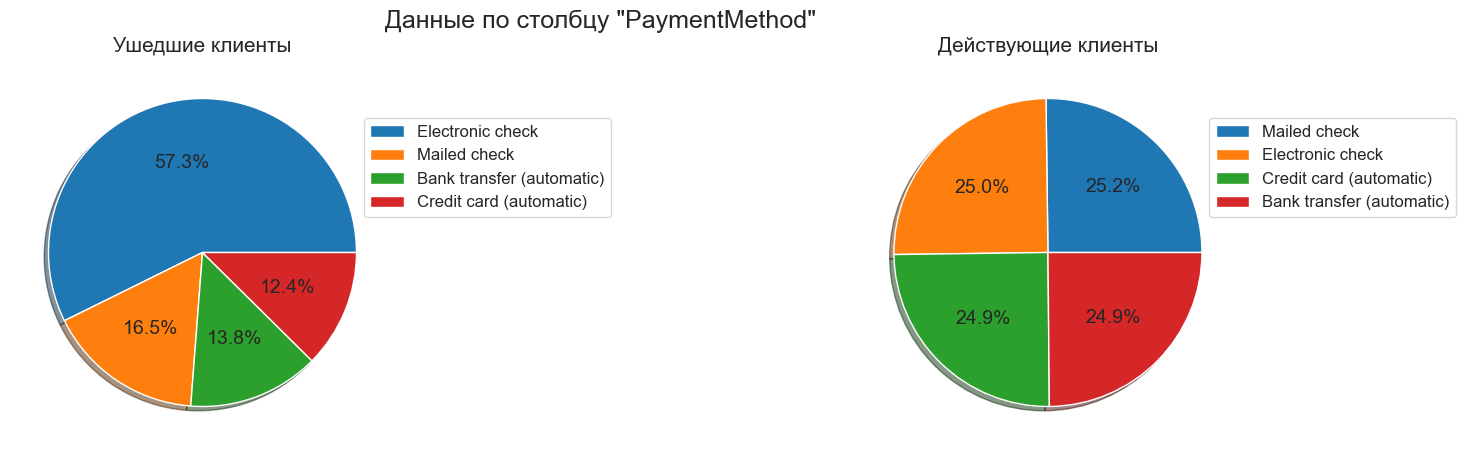

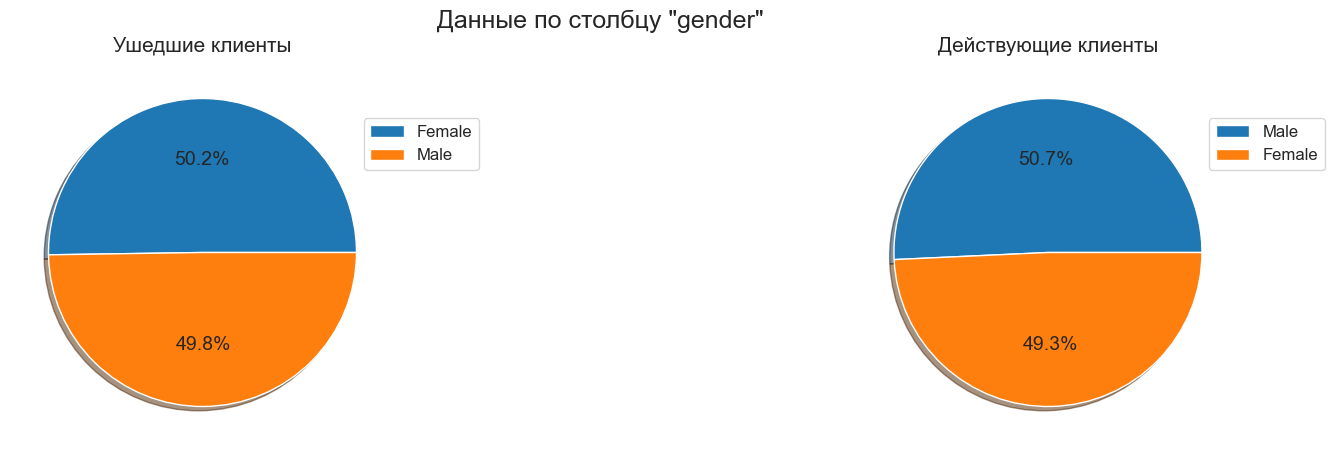

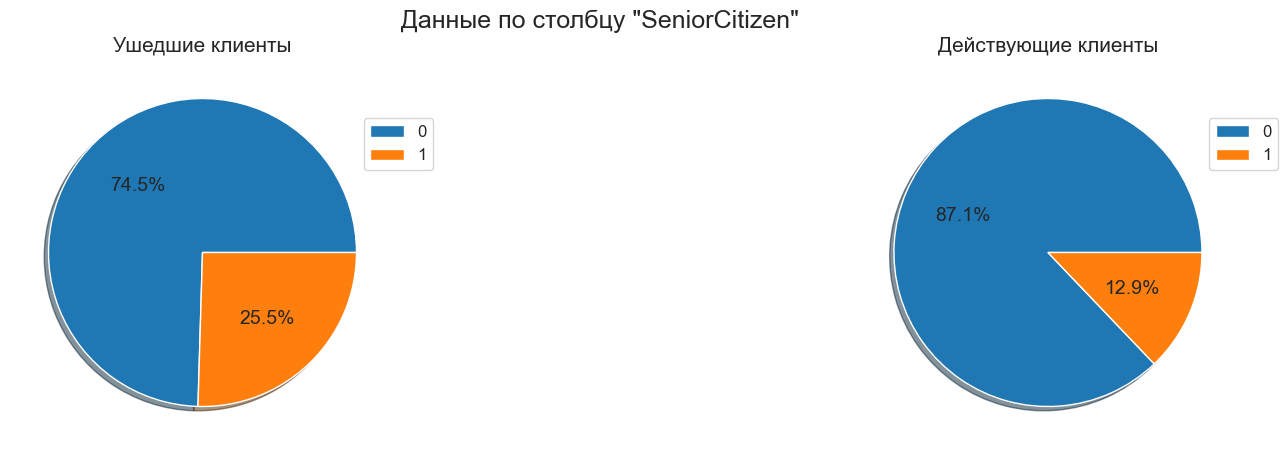

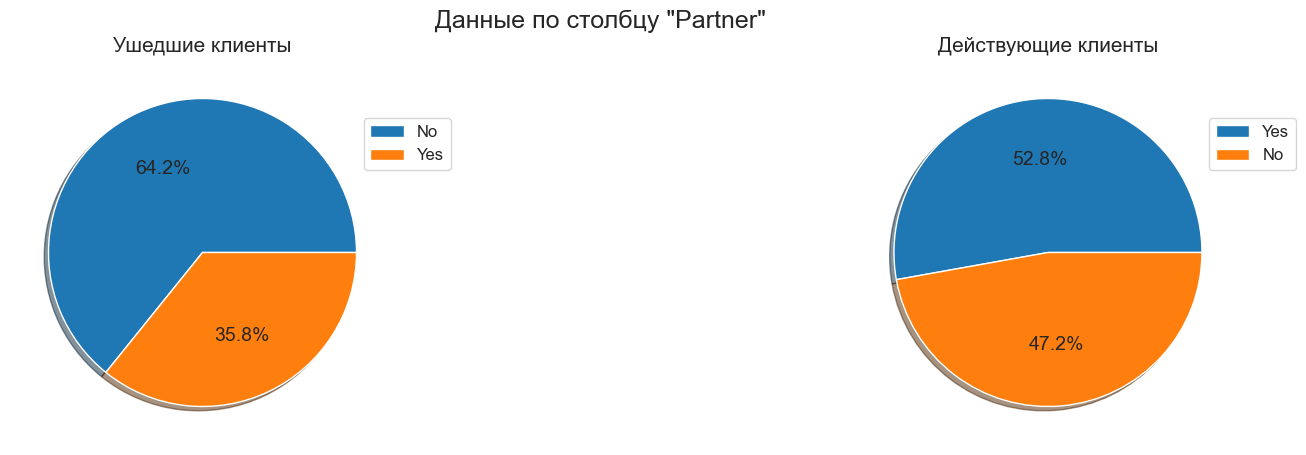

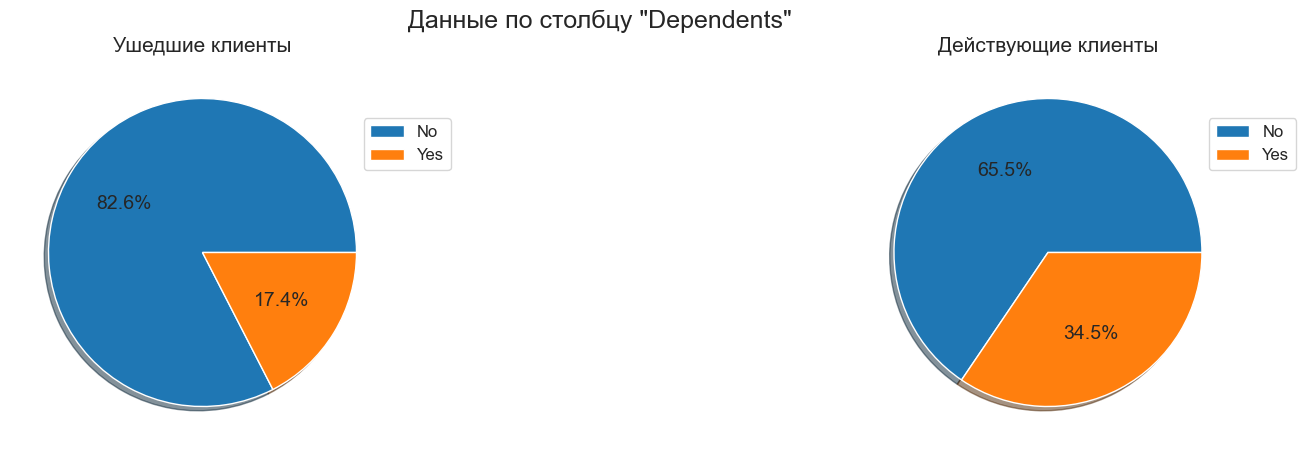

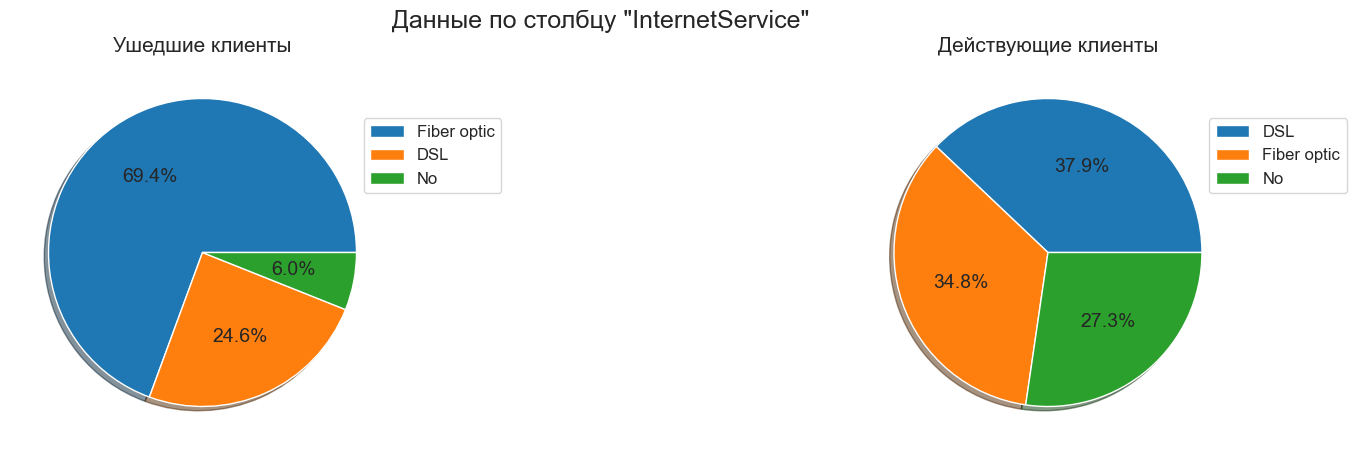

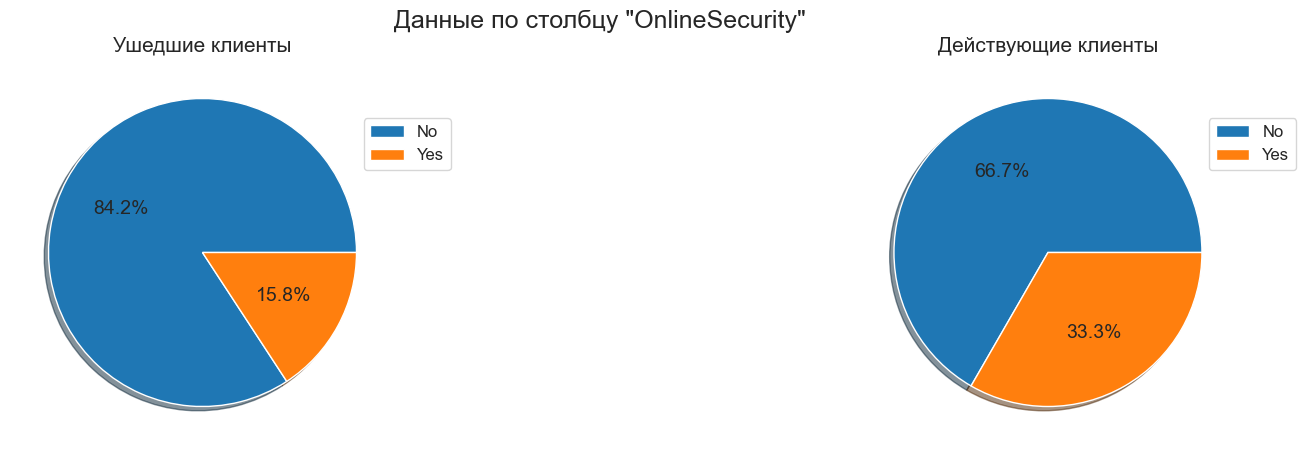

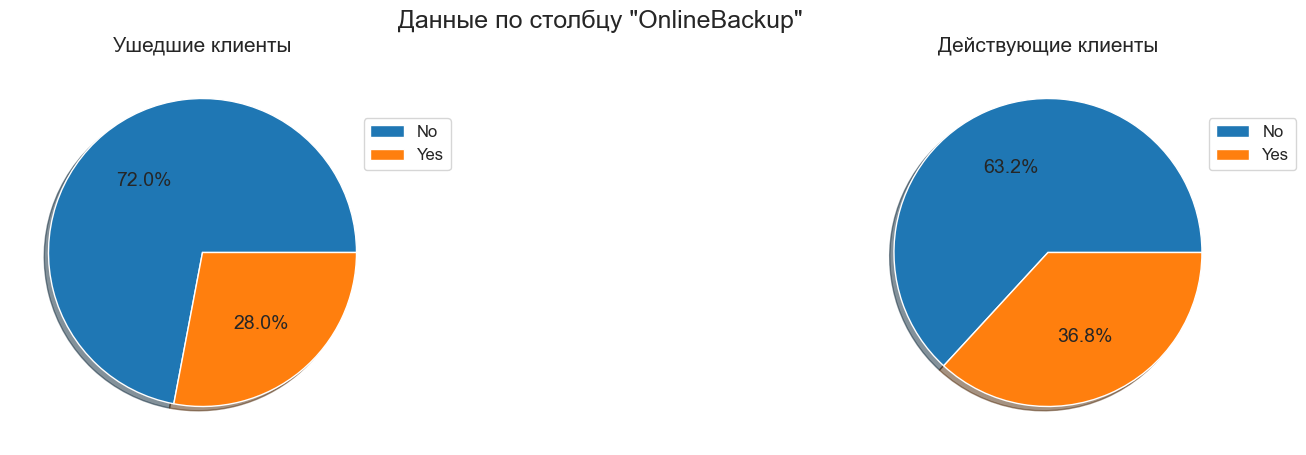

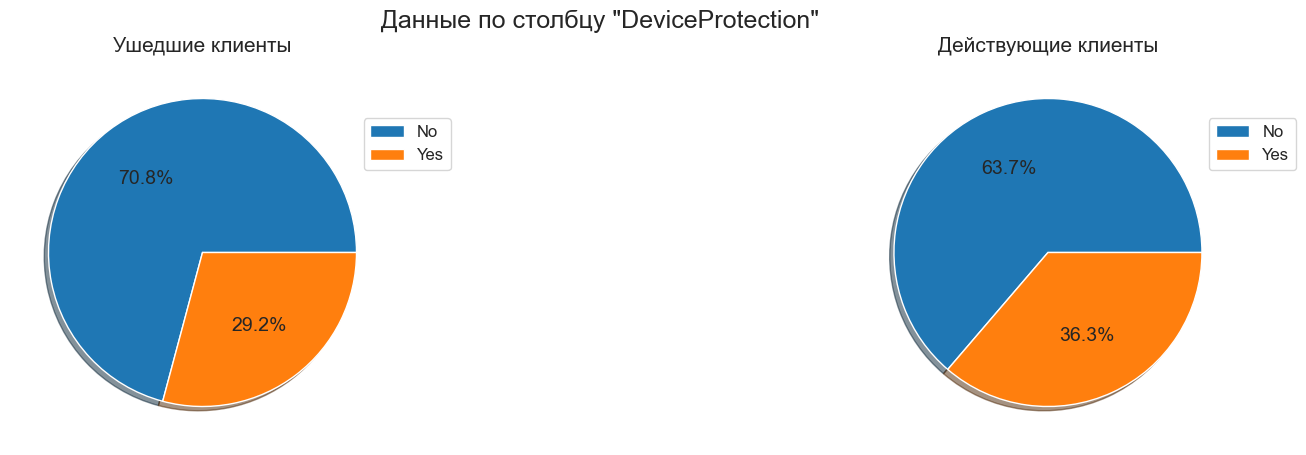

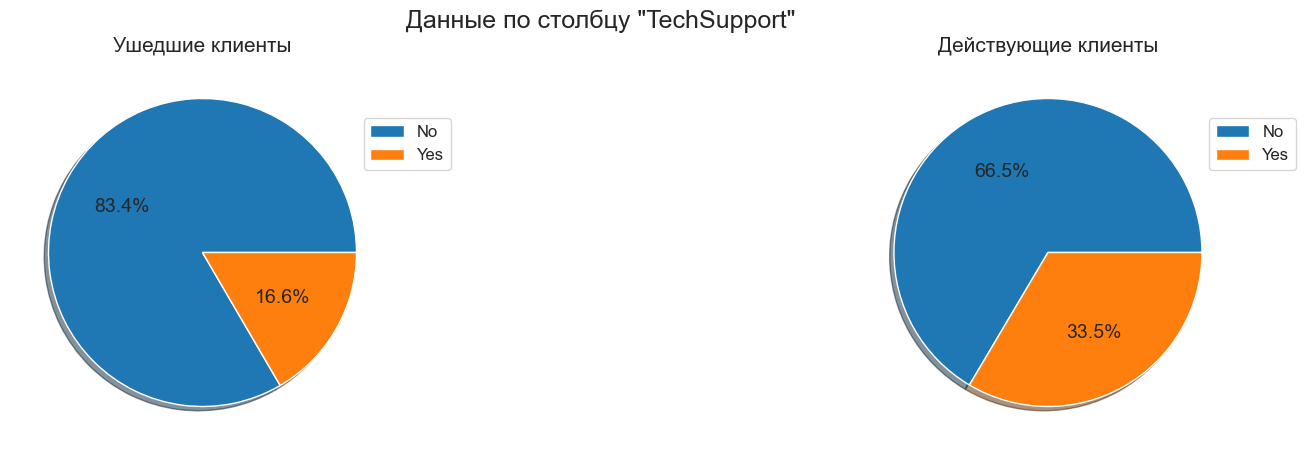

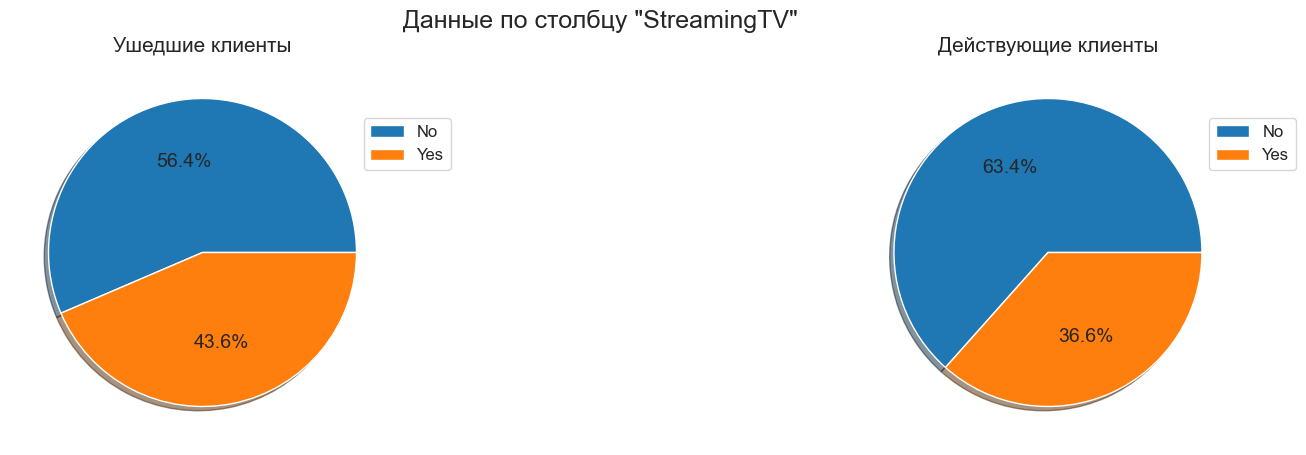

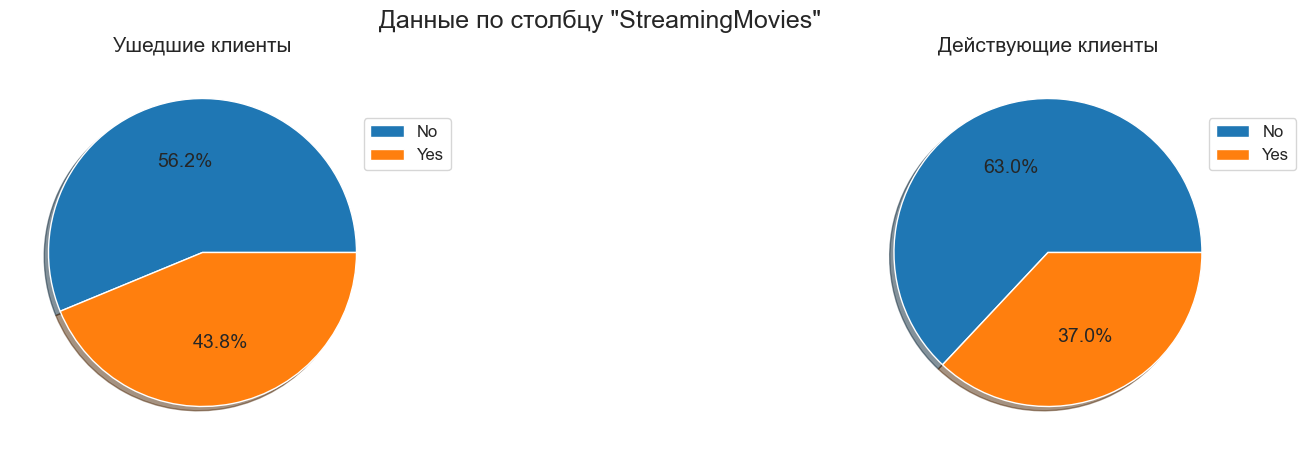

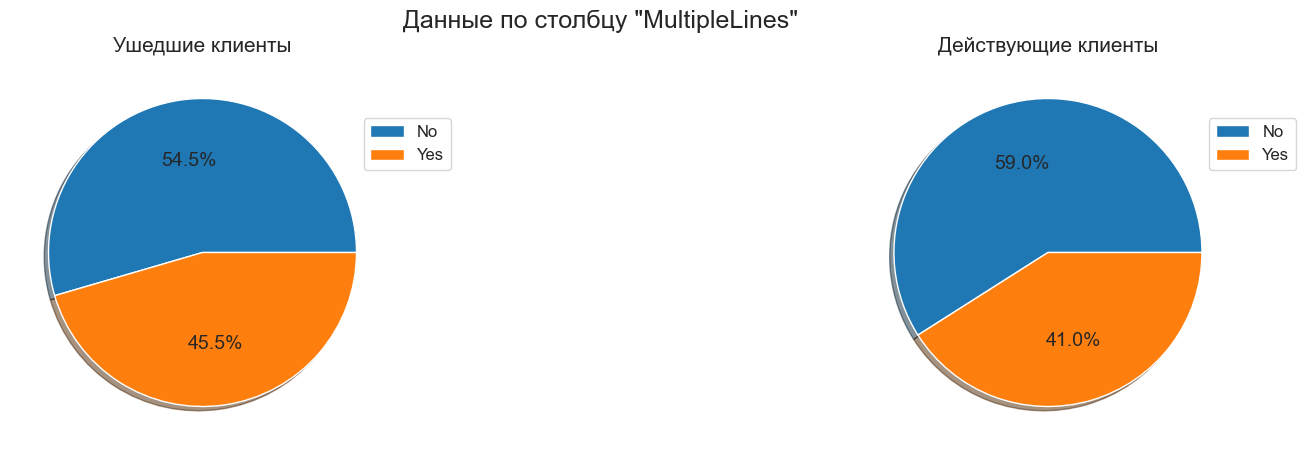

In [24]:
for column in categorical:
    plot_categorical(column)

Интересны отличия между группами по следующим признакам:
    
    - 'Type': для ушедших клиентов характерен более короткий срок договора;
    - 'PaymentMethod': для ушедших клиентов в большей степени характерна категория 'Electronic check';        
    - 'SeniorCitizen': для ушедших клиентов доля пенсионеров в 2 раза выше;
    - 'Dependents': для ушедших клиентов доля клиентов с детьми в 2 раза ниже;    
    - 'InternetService': для ушедших клиентов в большей степени характерна категория 'Fiber optic';  
    - 'OnlineSecurity': доля действующих клиентов, использующих данную опцию, в 2 раза выше;
    - 'TechSupport': доля действующих клиентов, использующих данную опцию, в 2 раза выше.        

**Вывод**

Классы не сбалансированы: 73% - действующие клиенты.

Наблюдаемые различия между группами:

 - Среднее значение ежемесячных расходов выше для категории клиентов разорвавших договор, при этом стандартное отклонение для этой группы ниже. 
 - Для действующих клиентов характерен глобальный максимум по признаку 'MonthlyCharges' вблизи min значения. 
 - 'Type': для ушедших клиентов характерен более короткий срок договора.
 - 'PaymentMethod': для ушедших клиентов в большей степени характерна категория 'Electronic check'.        
 - 'SeniorCitizen': для ушедших клиентов доля пенсионеров в 2 раза выше.
 - 'Dependents': для ушедших клиентов доля клиентов с детьми в 2 раза ниже.   
 - 'InternetService': для ушедших клиентов в большей степени характерна категория 'Fiber optic'.  
 - 'OnlineSecurity': доля действующих клиентов, использующих данную опцию, в 2 раза выше.
 - 'TechSupport': доля действующих клиентов, использующих данную опцию, в 2 раза выше.     


## Обучение модели

### Разделение данных на выборки

In [25]:
features = data.drop(['exited'], axis=1)
target = data['exited']

In [26]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345, stratify=target)

In [27]:
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(5282, 18) (5282,) (1761, 18) (1761,)


### OHE и масштабирование признаков

In [28]:
scaler = StandardScaler()
scaler.fit(features_train[numerical])
df_scaler_train = scaler.transform(features_train[numerical])
df_scaler_test = scaler.transform(features_test[numerical]) 

df_scaler_train = pd.DataFrame(df_scaler_train, columns=numerical)
df_scaler_test = pd.DataFrame(df_scaler_test, columns=numerical)

In [29]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
ohe.fit(features_train[categorical])
df_ohe_train = ohe.transform(features_train[categorical])
df_ohe_test = ohe.transform(features_test[categorical]) 

df_ohe_train = pd.DataFrame(df_ohe_train, columns=ohe.get_feature_names_out())
df_ohe_test = pd.DataFrame(df_ohe_test, columns=ohe.get_feature_names_out())

In [30]:
features_train = pd.concat([df_scaler_train, df_ohe_train], axis=1)
features_test = pd.concat([df_scaler_test, df_ohe_test], axis=1)

In [31]:
X_train_tensor = torch.FloatTensor(np.array(features_train)) 
y_train_tensor = torch.FloatTensor(np.array(target_train.values))
X_test_tensor = torch.FloatTensor(np.array(features_test))
y_test_tensor = torch.FloatTensor(np.array(target_test.values))

### Выбор модели

Создадим класс для нейронки.

In [32]:
class Model_improve(nn.Module):
    def __init__(self, n_hidden_neurons_1=10, n_hidden_neurons_2=10, activation_1=nn.ELU(), activation_2=nn.ELU(), 
                 activation_3=nn.Sigmoid(), dropout_1=0, dropout_2=0, optimizer=torch.optim.Adam):
        super(Model_improve, self).__init__()
        
        
        self.layer1 = nn.Linear(X_train_tensor.shape[1], n_hidden_neurons_1)
        self.act1 = activation_1 
        self.dp1 = nn.Dropout(dropout_1)
        
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = activation_2    
        self.dp2 = nn.Dropout(dropout_2)
        
        self.layer3 = nn.Linear(n_hidden_neurons_2, 1)
        self.act3 = activation_3    
        
        self.layer_names = ['layer1', 'layer2', 'layer3']
        self.optimizer = optimizer
        
    def init_weights(self):
        for layer in self.layer_names:
            if type(layer) == nn.Linear: 
                nn.init.normal_(layer.weight, mean= 0.0, std=1.14)
                nn.init.normal_(layer.bias, mean=-0.5, std=1.0) 
    
           
    def forward(self, x):
        
        self.init_weights()
        
        
        x = self.layer1(x)
        x = self.act1(x)
        x = self.dp1(x)
        
        x = self.layer2(x)
        x = self.act2(x)
        x = self.dp2(x)
        
        x = self.layer3(x)
        x = self.act3(x)
        return x    

In [33]:
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)


scorers = make_scorer(roc_auc_score) 


classifiers = [
                NeuralNetClassifier(module=Model_improve, 
                                      verbose=0,
                                      batch_size=8,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=500, 
                                      lr=0.001,
                                      train_split=skorch.dataset.ValidSplit(10), 
                                      criterion=torch.nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=scorers, lower_is_better=False, name='roc_auc')),
                ('estoper', EarlyStopping(lower_is_better=False, monitor='roc_auc', patience=5))
                                                ]
                                    ), 
                LogisticRegression(),
                DecisionTreeClassifier(random_state = 12345),
                RandomForestClassifier(random_state = 12345),
                LGBMClassifier(random_state = 12345)
              ]

classifiers_dict = {0: 'SkorchClassifier',
                    1: 'LogisticRegression',
                    2: 'DecisionTree',
                    3: 'RandomForest',
                    4: 'LGBM'
                    }


param = {    0:{'module__n_hidden_neurons_1': [50, 100],
                'module__n_hidden_neurons_2': [50, 100],                
        
                'module__dropout_1': [0, 0.1],
                'module__dropout_2': [0, 0.1],
    
                'module__activation_1': [nn.ELU(), nn.ReLU(), nn.Tanh()],
                'module__activation_2': [nn.ELU(), nn.ReLU(), nn.Tanh()],
                     
                'optimizer__lr': [0.01],
                'lr': [0.01],
                'batch_size': [100]},    
    
    
             1:{'class_weight': [None, 'balanced']},
    
             2:{'max_depth': [2,4,8,16],
                'min_samples_leaf': [1,3,5],
                'class_weight': [None, 'balanced']},
                
             3:{'n_estimators': [300, 500],
                'max_depth': range(2,10),
                'min_samples_leaf': [1,3,5],
                'class_weight': [None, 'balanced']},
              
             4:{'learning_rate': [0.01,0.1,0.2],
                'num_leaves': [2,3,5,10],
                'max_depth': range(2,10),
                'n_estimators': [300, 500,]}
           
        }


best_roc_auc = 0
best_param = 0
best_model = ''
best_model_index = ''
index = 0


for classifier in classifiers:

    start = time.time()
    
    
    if index != 0:     
        model = GridSearchCV(estimator=classifier, param_grid=param[index], scoring='roc_auc', cv=3) 
        model.fit(features_train, target_train)
        predicted_train = model.best_estimator_.predict_proba(features_train)[:, 1]   
      
        
    else:  
        f1 = make_scorer(f1_score , average='macro')
        model = GridSearchCV(estimator=classifier, param_grid=param[index], scoring=f1, cv=3) 
        model.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 
        predicted_train = model.best_estimator_.predict_proba(X_train_tensor)
        
    
    roc_auc_train =  roc_auc_score(target_train, predicted_train)
       
    
    if roc_auc_train > best_roc_auc:
        best_roc_auc = roc_auc_train
        best_model_index = classifiers_dict[index]
        best_model = classifier
        best_param = model.best_params_
       
   

    end = time.time()       
    print('\nМодель: {}'.format(classifiers_dict[index]))
    print('Лучшие параметры : {}'.format(model.best_params_))
    print('Лучшее значение "roc_auc" на valid: {:.4f}'.format(roc_auc_train))
    print("Общее время:", exec_time(start,end))
    index += 1


Модель: SkorchClassifier
Лучшие параметры : {'batch_size': 100, 'lr': 0.01, 'module__activation_1': ELU(alpha=1.0), 'module__activation_2': ELU(alpha=1.0), 'module__dropout_1': 0, 'module__dropout_2': 0, 'module__n_hidden_neurons_1': 50, 'module__n_hidden_neurons_2': 50, 'optimizer__lr': 0.01}
Лучшее значение "roc_auc" на valid: 0.8459
Общее время: 00:04:30

Модель: LogisticRegression
Лучшие параметры : {'class_weight': None}
Лучшее значение "roc_auc" на valid: 0.8422
Общее время: 00:00:00

Модель: DecisionTree
Лучшие параметры : {'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 1}
Лучшее значение "roc_auc" на valid: 0.8370
Общее время: 00:00:01

Модель: RandomForest
Лучшие параметры : {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 500}
Лучшее значение "roc_auc" на valid: 0.8966
Общее время: 00:04:32

Модель: LGBM
Лучшие параметры : {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 5}
Лучшее значение "roc_auc" на valid: 

**Вывод**

In [34]:
print('\nМодель с лучшим значением "roc_auc" на valid: {}'.format(best_model_index))
print('Лучшее значение "roc_auc" на valid: {:.4f}'.format(best_roc_auc))
print('Параметры лучшей модели:', best_param)


Модель с лучшим значением "roc_auc" на valid: RandomForest
Лучшее значение "roc_auc" на valid: 0.8966
Параметры лучшей модели: {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 500}


### Тестирование модели

In [35]:
f_model = RandomForestClassifier(random_state = 12345)
f_model.set_params(**best_param)
f_model.fit(features_train, target_train)
predicted_test = f_model.predict_proba(features_test)[:, 1]
roc_auc_test = roc_auc_score(target_test, predicted_test)
print('Значение "roc_auc" на test: {:.4f}'.format(roc_auc_test))

Значение "roc_auc" на test: 0.8418


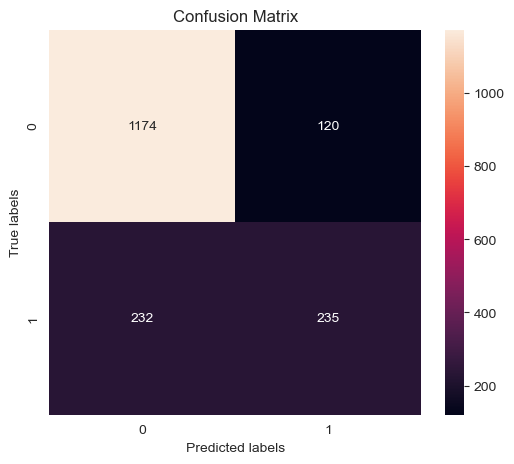

In [36]:
predicted_test = f_model.predict(features_test)
matrix = confusion_matrix(target_test, predicted_test)
plt.figure(figsize=(6, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Модель определила правильно только половину класса '1'. Вероятно, это связано с дисбалансом и малым количеством тренировочных данных. 

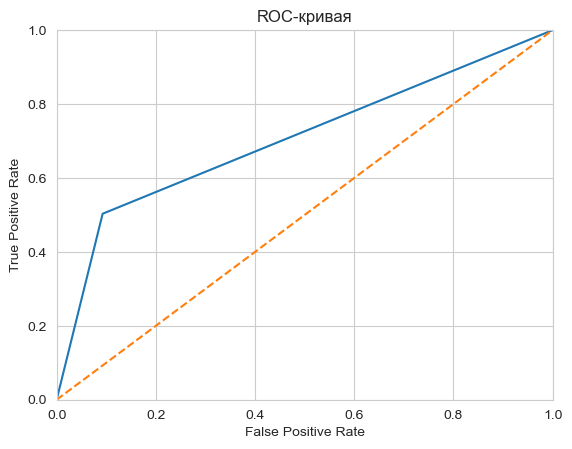

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, predicted_test) 
sns.lineplot(x=fpr, y=tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

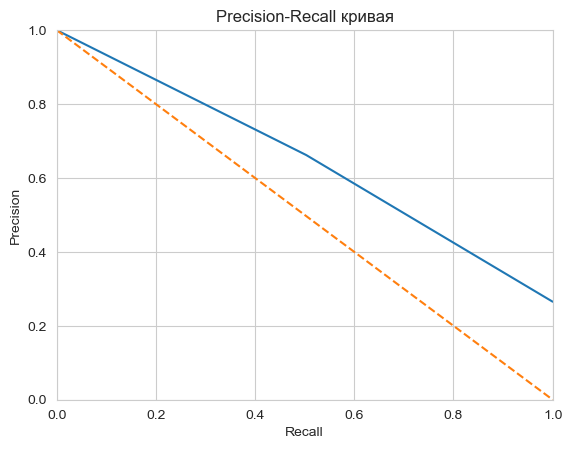

In [38]:
precision, recall, thresholds = precision_recall_curve(target_test, predicted_test) 
sns.lineplot(x=recall, y=precision)
plt.plot([0, 1], [1, 0], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.show()

In [39]:
def feature_importance(model):
    feats = {}
    for feature, importance in zip(features_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
    importances = importances.sort_values(by='Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    display(importances.head(10))

In [40]:
feature_importance(f_model)

,Features,Importance
0,TotalCharges,0.217392
1,InternetService_Fiber optic,0.129475
2,MonthlyCharges,0.112240
3,Type_Two year,0.102468
4,PaymentMethod_Electronic check,0.088400
5,Type_One year,0.052304
6,OnlineSecurity_Yes,0.044001
7,days,0.042688
8,InternetService_No,0.039795
9,TechSupport_Yes,0.028910


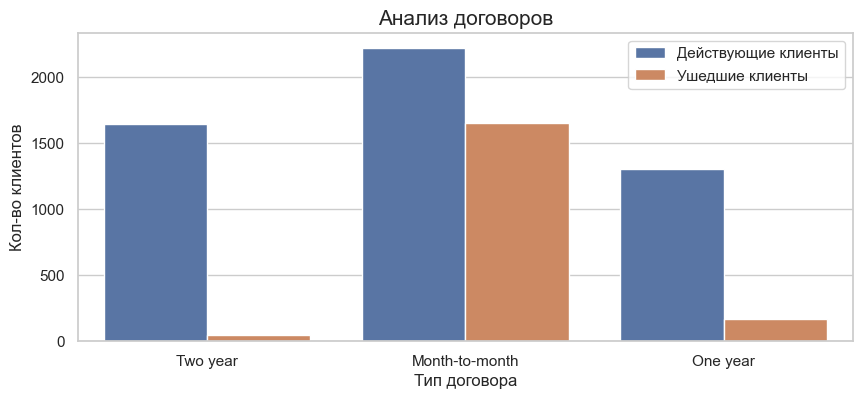

In [41]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))
sns.countplot(x ='Type', data = data, hue='exited')
plt.xlabel('Тип договора', fontsize=12)
plt.ylabel('Кол-во клиентов', fontsize=12)
plt.title('Анализ договоров', fontsize=15)
plt.legend(['Действующие клиенты', 'Ушедшие клиенты'])
plt.draw()

**Вывод**

In [42]:
print('\nМодель с лучшим значением "roc_auc" на valid: {}'.format(best_model_index))
print('Значение "roc_auc" на test: {:.4f}'.format(roc_auc_test))    
print('Параметры лучшей модели:', best_param)


Модель с лучшим значением "roc_auc" на valid: RandomForest
Значение "roc_auc" на test: 0.8418
Параметры лучшей модели: {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 5, 'n_estimators': 500}


"Портрет" типичного клиента, разорвавшего договор: 

    - заключил краткосрочный договор;
    - не имеет детей / дети уже взрослые (пенсионер);
    - использует интернет-подключение через оптоволоконный кабель;
    - использует тип платежа 'Electronic check';
    - не пользуется услугой 'Интернет-безопасность (OnlineSecurity)';
    - не пользуется услугой 'Выделенная линия технической поддержки (TechSupport)'.
    
    
Возможные рекомендации:
    
    - предложить клиенту бонус при заключении долгосрочного договора;
    - проверить стоимость и качество услуги "Интернет через оптоволоконный кабель";
    - рассмотреть возможность предоставления услуги "TechSupport" на более выгодных условиях с целью увеличения охвата аудитории;
    - добавить функцию "настроить автоплатеж" в личном кабинете клиента (если она отсутствует).

P.S. Борьба с дисбалансом через 'upsample' метрику ухудшает.